## Data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/train.csv')
df_preprocessed = pd.get_dummies(df, drop_first=True, dtype=int).astype(float)
X = df_preprocessed.drop(['accident_risk', 'id'], axis=1)
y = df_preprocessed['accident_risk']

test_df = pd.read_csv('data/test.csv')

## Create output

In [3]:
def submission_generator(trained_model, test_df):
    preprocessed_df = pd.get_dummies(test_df, drop_first=True, dtype=int).astype(float).drop('id', axis=1)

    return pd.concat([test_df['id'], pd.Series(clf.predict(preprocessed_df))], axis=1).rename({0: 'accident_risk'}, axis=1)

## Evaluation Model

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

kf = KFold(5, shuffle=True)

def evaluate_model(model_object, X, verbose=True, **kwargs):
    rmses = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        train_data = X.iloc[train_index]
        test_data = X.iloc[test_index]

        train_output = y.iloc[train_index]
        test_output = y.iloc[test_index]

        model = model_object(**kwargs)
        model.fit(train_data, train_output)

        y_pred = model.predict(test_data)

        rmse = root_mean_squared_error(y_pred, test_output)
        if verbose:
            print(f"fold: {i}, rmse: {rmse:.6f}")
        rmses.append(rmse)

    return np.mean(rmses)

## Models

### Linear Regression

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [9]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

y_pred = linear_regression.predict(X_test)

In [11]:
root_mean_squared_error(y_pred, y_test)

0.07330965157891249

In [13]:
kf = KFold(5, shuffle=True)
kf.get_n_splits(X)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    linear_regression.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = linear_regression.predict(X.iloc[test_index])
    rmse = root_mean_squared_error(y.iloc[test_index], y_pred)
    print(f"fold: {i}, rmse: {rmse}")

fold: 0, rmse: 0.07342207604557457
fold: 1, rmse: 0.07333548214978462
fold: 2, rmse: 0.07347474666973686
fold: 3, rmse: 0.07360227905727774
fold: 4, rmse: 0.07364548672122433


### Decision Tree

In [31]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import numpy as np

In [41]:
max_depths = np.arange(2, 40, 5)
min_samples_splits = np.arange(2, 500, 20)

rmses = np.zeros((len(max_depths), len(min_samples_splits)))

for i, max_depth in enumerate(max_depths):
    for j, min_samples_split in enumerate(min_samples_splits):
        cv_rmse = evaluate_model(DecisionTreeRegressor,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split)
        print(f"max_depth: {max_depth}, min_samples_split: {min_samples_split}, rmse: {cv_rmse:.6f}")
        rmses[i, j] = cv_rmse

max_depth: 2, min_samples_split: 2, rmse: 0.118667
max_depth: 2, min_samples_split: 22, rmse: 0.118668
max_depth: 2, min_samples_split: 42, rmse: 0.118667
max_depth: 2, min_samples_split: 62, rmse: 0.118668
max_depth: 2, min_samples_split: 82, rmse: 0.118668
max_depth: 2, min_samples_split: 102, rmse: 0.118667
max_depth: 2, min_samples_split: 122, rmse: 0.118668
max_depth: 2, min_samples_split: 142, rmse: 0.118668
max_depth: 2, min_samples_split: 162, rmse: 0.118668
max_depth: 2, min_samples_split: 182, rmse: 0.118667
max_depth: 2, min_samples_split: 202, rmse: 0.118667
max_depth: 2, min_samples_split: 222, rmse: 0.118668
max_depth: 2, min_samples_split: 242, rmse: 0.118667
max_depth: 2, min_samples_split: 262, rmse: 0.118668
max_depth: 2, min_samples_split: 282, rmse: 0.118668
max_depth: 2, min_samples_split: 302, rmse: 0.118667
max_depth: 2, min_samples_split: 322, rmse: 0.118668
max_depth: 2, min_samples_split: 342, rmse: 0.118668
max_depth: 2, min_samples_split: 362, rmse: 0.118668

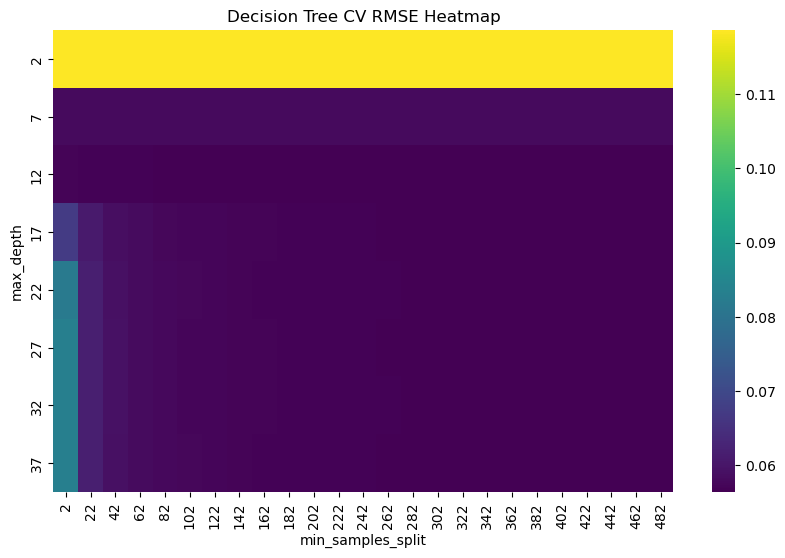

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(rmses, 
            xticklabels=min_samples_splits,
            yticklabels=max_depths,
            cmap="viridis", 
            fmt=".2f")

plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.title("Decision Tree CV RMSE Heatmap")
plt.show()

In [63]:
np.unravel_index(np.argmin(rmses), rmses.shape)

(2, 21)

In [69]:
rmses[2][21]

0.05638241152007821

### Random Forst

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [89]:
evaluate_model(RandomForestRegressor, max_features='sqrt')

fold: 0, rmse: 0.059148
fold: 1, rmse: 0.059490
fold: 2, rmse: 0.058975
fold: 3, rmse: 0.058966
fold: 4, rmse: 0.058859


0.05908786009723153

### Random Forst + noise, feature selection

#### Feature Selection

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

import seaborn as sns
import numpy as np

In [9]:
X_copy = X.copy()
X_copy['noise'] = np.random.normal(0, 0.5, X.iloc[:, 0].shape)

X_noise_train, X_noise_test, y_noise_train, y_noise_test = train_test_split(X_copy, y, test_size=0.3)

In [11]:
clf = RandomForestRegressor(max_features='sqrt')
clf.fit(X_noise_train, y_noise_train)
y_noise_pred = clf.predict(X_noise_test)
root_mean_squared_error(y_noise_test, y_noise_pred)

0.05772420102039242

<Axes: xlabel='feature_importances', ylabel='feature_names'>

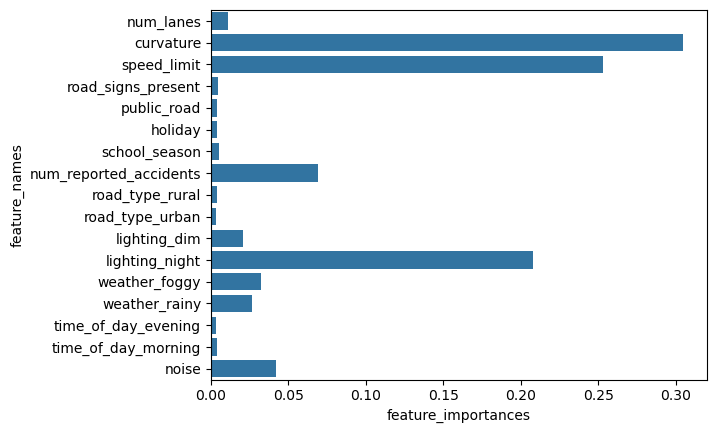

In [13]:
data = {
    "feature_importances": clf.feature_importances_,
    "feature_names": clf.feature_names_in_,
}
sns.barplot(data=data, x='feature_importances', y='feature_names')

In [15]:
df_fi = pd.DataFrame(data)
df_fi = df_fi.set_index('feature_names')
selected_features = df_fi[df_fi > df_fi.loc['noise'].iloc[0]].dropna()
selected_features

,feature_importances
feature_names,
curvature,0.304897
speed_limit,0.252762
num_reported_accidents,0.069109
lighting_night,0.207965


#### Random Forest and Selected features

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

import seaborn as sns
import numpy as np

In [19]:
selected_feature_names = selected_features.index

X_selected = X.loc[:, selected_feature_names]

In [21]:
evaluate_model(RandomForestRegressor, X_selected, max_features='sqrt')

fold: 0, rmse: 0.070764
fold: 1, rmse: 0.070396
fold: 2, rmse: 0.070678
fold: 3, rmse: 0.070872
fold: 4, rmse: 0.070716


0.07068511307153134

### SVM + w/selection_features

In [249]:
from sklearn.svm import SVR

In [ ]:
evaluate_model(SVR, X)

### XGBoost

In [33]:
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [47]:
evaluate_model(XGBRegressor, X, n_estimators=1000)

fold: 0, rmse: 0.057106
fold: 1, rmse: 0.056844
fold: 2, rmse: 0.056968
fold: 3, rmse: 0.056442
fold: 4, rmse: 0.056935


0.05685897968259945

### Lightgbm

In [50]:
from lightgbm import LGBMRegressor

In [54]:
evaluate_model(LGBMRegressor, X, n_estimators=500, learning_rate=0.01)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352580
fold: 0, rmse: 0.056453
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352248
fold: 1, rmse: 0.056515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003865 seconds.
You can set `force_row_wise=true` to

0.05656192750201241

## Parameter tuning (Optuna)

In [4]:
import optuna

### Linear Regression (Ridge/Lasso)

In [54]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold

#### Optuna

In [57]:
study = optuna.create_study()
study.optimize(objective, n_trials=500)

[I 2025-10-23 22:40:23,426] A new study created in memory with name: no-name-b8d1c22b-4675-4842-9e7b-775a248e4421
[I 2025-10-23 22:40:23,866] Trial 0 finished with value: 0.15026301410839812 and parameters: {'regularization': 'lasso', 'alpha': 0.08110313785109134}. Best is trial 0 with value: 0.15026301410839812.
[I 2025-10-23 22:40:24,366] Trial 1 finished with value: 0.07352407458616736 and parameters: {'regularization': 'lasso', 'alpha': 0.00028441890943038813}. Best is trial 1 with value: 0.07352407458616736.
[I 2025-10-23 22:40:24,839] Trial 2 finished with value: 0.07538083810789468 and parameters: {'regularization': 'lasso', 'alpha': 0.0026954506733211617}. Best is trial 1 with value: 0.07352407458616736.
[I 2025-10-23 22:40:25,299] Trial 3 finished with value: 0.077046440574375 and parameters: {'regularization': 'lasso', 'alpha': 0.003725026773430398}. Best is trial 1 with value: 0.07352407458616736.
[I 2025-10-23 22:40:25,783] Trial 4 finished with value: 0.08549396367566939 a

In [55]:
kf = KFold(5, shuffle=True)

def objective(trial):
    reg_type = trial.suggest_categorical("regularization", ["ridge", "lasso"])
    alpha = trial.suggest_float("alpha", 1e-4, 10.0, log=True)

    if reg_type == "ridge":
        model = Ridge(alpha=alpha)
    else:
        model = Lasso(alpha=alpha, max_iter=10000)

    rmses = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmses.append(root_mean_squared_error(y_test, y_pred))

    return np.mean(rmses)

#### Full train

In [59]:
clf = Ridge(alpha=1.2882367889811759)
clf.fit(X, y)

submission = submission_generator(clf, test_df)
submission.to_csv('LR_optuna.csv', index=False)

### Linear Regression (polynomials)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

import numpy as np

#### Optuna

In [6]:
kf = KFold(5, shuffle=True)

def objective(trial):
    degree = trial.suggest_int("degree", 2, 3)
    alpha = trial.suggest_float("alpha", 1e-4, 10.0, log=True)
    
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("reg", Ridge(alpha=alpha))
    ])
    
    rmses = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmses.append(root_mean_squared_error(y_test, y_pred))
    
    return np.mean(rmses)

In [7]:
study = optuna.create_study()
study.optimize(objective, n_trials=25)

[I 2025-10-23 22:50:17,614] A new study created in memory with name: no-name-1108c1a4-3ede-4dc4-a1bf-4e4dfbe50765
[I 2025-10-23 22:50:21,245] Trial 0 finished with value: 0.06773593445937301 and parameters: {'degree': 2, 'alpha': 0.00011976562508265396}. Best is trial 0 with value: 0.06773593445937301.
/home/woxane/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=8.78623e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/woxane/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=8.80046e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/woxane/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=8.81092e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="po

#### Full train

In [8]:
clf = Pipeline([
    ("poly", PolynomialFeatures(degree=study.best_params['degree'], include_bias=False)),
    ("reg", Ridge(alpha=study.best_params['alpha']))
])
clf.fit(X, y)

submission = submission_generator(clf, test_df)
submission.to_csv('LRPOLY_optuna.csv', index=False)

/home/woxane/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.92337e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


### Decision Tree

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

import numpy as np

#### Optuna

In [8]:
kf = KFold(5, shuffle=True)

In [9]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 1000)
    min_samples_split =  trial.suggest_int('min_samples_split', 2, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 200)

    clf = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    
    rmses = []
    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        rmse = root_mean_squared_error(y_pred, y_test)
        rmses.append(rmse)

    return np.mean(rmses)

In [10]:
study = optuna.create_study()
study.optimize(objective, n_trials=150)

[I 2025-10-23 21:06:16,022] A new study created in memory with name: no-name-d46c504d-f13a-4b28-8213-1e614b5ddd59
[I 2025-10-23 21:06:18,769] Trial 0 finished with value: 0.056949524994559284 and parameters: {'max_depth': 284, 'min_samples_split': 158, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.056949524994559284.
[I 2025-10-23 21:06:21,238] Trial 1 finished with value: 0.056644933469087465 and parameters: {'max_depth': 285, 'min_samples_split': 410, 'min_samples_leaf': 55}. Best is trial 1 with value: 0.056644933469087465.
[I 2025-10-23 21:06:23,791] Trial 2 finished with value: 0.056653095912332606 and parameters: {'max_depth': 739, 'min_samples_split': 277, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.056644933469087465.
[I 2025-10-23 21:06:26,306] Trial 3 finished with value: 0.05679158949565812 and parameters: {'max_depth': 166, 'min_samples_split': 58, 'min_samples_leaf': 140}. Best is trial 1 with value: 0.056644933469087465.
[I 2025-10-23 21:06:29,303] Tria

#### Full train

In [13]:
clf = DecisionTreeRegressor(**study.best_params)
clf.fit(X, y)

submission = submission_generator(clf, test_df)

### Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

#### Optuna

In [46]:
kf = KFold(5, shuffle=True)

In [49]:
def objective(trials):
    n_estimators = trials.suggest_int('n_estimator', 5, 256)
    max_depth = trials.suggest_int('max_depth', 2, 32)
    min_samples_split = trials.suggest_int('min_samples_split', 1, 512)
    min_samples_leaf = trials.suggest_int('min_samples_leaf', 1, 16)
    max_features = trials.suggest_categorical('max_features', ['sqrt', 'log2'])

    clf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        
    )
    
    rmses = []
    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        rmse = root_mean_squared_error(y_pred, y_test)
        rmses.append(rmse)

    return np.mean(rmses)

In [51]:
study = optuna.create_study()
study.optimize(objective, n_trials=25)

[I 2025-10-23 21:58:26,443] A new study created in memory with name: no-name-670dea63-2751-4454-a3a9-f6a27656b6b2
[I 2025-10-23 21:58:32,569] Trial 0 finished with value: 0.10149763658800984 and parameters: {'n_estimator': 37, 'max_depth': 3, 'min_samples_split': 306, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.10149763658800984.
[I 2025-10-23 21:58:41,165] Trial 1 finished with value: 0.11787509225650242 and parameters: {'n_estimator': 73, 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.10149763658800984.
[I 2025-10-23 21:59:28,641] Trial 2 finished with value: 0.09006898089354026 and parameters: {'n_estimator': 224, 'max_depth': 4, 'min_samples_split': 73, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 2 with value: 0.09006898089354026.
[I 2025-10-23 21:59:52,867] Trial 3 finished with value: 0.059742019127856316 and parameters: {'n_estimator': 48, 'max_depth': 18, 

#### Full train

In [53]:
clf = RandomForestRegressor(n_estimators=256, max_depth=23, min_samples_split=6, min_samples_leaf=2, max_features='log2')
clf.fit(X, y)

submission = submission_generator(clf, test_df)
submission.to_csv('RFR_optuna.csv', index=False)

### LightGBM

In [22]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

#### Optuna

In [23]:
kf = KFold(5, shuffle=True)

In [24]:
def objective(trials):
    num_leaves = trials.suggest_int('num_leaves', 4, 256)
    max_depth = trials.suggest_int('max_depth', -1, 512)
    learning_rate = trials.suggest_float('learning_rate', 0.003, 0.3)
    n_estimators = trials.suggest_int('n_estimator', 24, 1024)

    clf = LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
    )

    rmses = []
    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        rmse = root_mean_squared_error(y_pred, y_test)
        rmses.append(rmse)

    return np.mean(rmses)

In [25]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2025-10-23 21:17:16,377] A new study created in memory with name: no-name-c22631b4-e6da-4fa3-ab9a-a89a80ee180b


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:17:22,950] Trial 0 finished with value: 0.05610241580920687 and parameters: {'num_leaves': 54, 'max_depth': 222, 'learning_rate': 0.057522464262502, 'n_estimator': 545}. Best is trial 0 with value: 0.05610241580920687.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352332
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:17:32,445] Trial 1 finished with value: 0.05610918843919953 and parameters: {'num_leaves': 70, 'max_depth': 55, 'learning_rate': 0.053185954766187725, 'n_estimator': 768}. Best is trial 0 with value: 0.05610241580920687.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352337
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:17:35,372] Trial 2 finished with value: 0.05622099285367991 and parameters: {'num_leaves': 195, 'max_depth': 175, 'learning_rate': 0.19768559420572654, 'n_estimator': 117}. Best is trial 0 with value: 0.05610241580920687.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:17:37,663] Trial 3 finished with value: 0.056291083986441615 and parameters: {'num_leaves': 68, 'max_depth': 388, 'learning_rate': 0.28918189167215336, 'n_estimator': 175}. Best is trial 0 with value: 0.05610241580920687.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352397
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:17:44,781] Trial 4 finished with value: 0.05628585671556653 and parameters: {'num_leaves': 14, 'max_depth': 119, 'learning_rate': 0.27950395283682006, 'n_estimator': 1015}. Best is trial 0 with value: 0.05610241580920687.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352509
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:17:59,239] Trial 5 finished with value: 0.05616542199569287 and parameters: {'num_leaves': 100, 'max_depth': 463, 'learning_rate': 0.006969038267573757, 'n_estimator': 689}. Best is trial 0 with value: 0.05610241580920687.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:03,620] Trial 6 finished with value: 0.056100185835800356 and parameters: {'num_leaves': 74, 'max_depth': 383, 'learning_rate': 0.09777772744210074, 'n_estimator': 309}. Best is trial 6 with value: 0.056100185835800356.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352210
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:06,075] Trial 7 finished with value: 0.05607809945933308 and parameters: {'num_leaves': 107, 'max_depth': 200, 'learning_rate': 0.13946174234673636, 'n_estimator': 116}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352208
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:09,044] Trial 8 finished with value: 0.056182849477549944 and parameters: {'num_leaves': 30, 'max_depth': 128, 'learning_rate': 0.2111898566465938, 'n_estimator': 298}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352481
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:14,623] Trial 9 finished with value: 0.056567803140317285 and parameters: {'num_leaves': 155, 'max_depth': 362, 'learning_rate': 0.20620527483355267, 'n_estimator': 319}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352532
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352542
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:15,965] Trial 10 finished with value: 0.05617278893451159 and parameters: {'num_leaves': 236, 'max_depth': -1, 'learning_rate': 0.13731186144139562, 'n_estimator': 27}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 414204, number of used features: 16
[LightGBM] [Info] Start training from score 0.352289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:21,297] Trial 11 finished with value: 0.0562003381441703 and parameters: {'num_leaves': 123, 'max_depth': 306, 'learning_rate': 0.1221085441942728, 'n_estimator': 329}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352507
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:29,721] Trial 12 finished with value: 0.05625374850590574 and parameters: {'num_leaves': 164, 'max_depth': 502, 'learning_rate': 0.09912968160637106, 'n_estimator': 453}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:33,066] Trial 13 finished with value: 0.056167490146114496 and parameters: {'num_leaves': 97, 'max_depth': 280, 'learning_rate': 0.16928780756649925, 'n_estimator': 205}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352263
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:40,524] Trial 14 finished with value: 0.05616311730114443 and parameters: {'num_leaves': 122, 'max_depth': 393, 'learning_rate': 0.08212516069667002, 'n_estimator': 468}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:42,189] Trial 15 finished with value: 0.05608737131683879 and parameters: {'num_leaves': 92, 'max_depth': 239, 'learning_rate': 0.16533190756496666, 'n_estimator': 74}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352493
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:43,490] Trial 16 finished with value: 0.05610903694319101 and parameters: {'num_leaves': 153, 'max_depth': 173, 'learning_rate': 0.25191717685144277, 'n_estimator': 41}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414204, number of used features: 16
[LightGBM] [Info] Start training from score 0.352500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:47,179] Trial 17 finished with value: 0.05622950194759056 and parameters: {'num_leaves': 195, 'max_depth': 235, 'learning_rate': 0.16690950257802822, 'n_estimator': 166}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:18:54,769] Trial 18 finished with value: 0.056435076696117026 and parameters: {'num_leaves': 95, 'max_depth': 320, 'learning_rate': 0.15452661313213695, 'n_estimator': 600}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:02,237] Trial 19 finished with value: 0.056552658558493195 and parameters: {'num_leaves': 40, 'max_depth': 211, 'learning_rate': 0.23360287619826814, 'n_estimator': 854}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:04,970] Trial 20 finished with value: 0.05619223779472175 and parameters: {'num_leaves': 252, 'max_depth': 108, 'learning_rate': 0.1819003204971554, 'n_estimator': 92}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352354
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:08,875] Trial 21 finished with value: 0.05613034451412709 and parameters: {'num_leaves': 78, 'max_depth': 437, 'learning_rate': 0.12040057182785499, 'n_estimator': 272}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352397
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:14,987] Trial 22 finished with value: 0.056158561136395266 and parameters: {'num_leaves': 116, 'max_depth': 340, 'learning_rate': 0.09582255660773978, 'n_estimator': 407}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:18,288] Trial 23 finished with value: 0.05612450123833214 and parameters: {'num_leaves': 80, 'max_depth': 269, 'learning_rate': 0.13331518458703737, 'n_estimator': 220}. Best is trial 7 with value: 0.05607809945933308.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352479
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:21,565] Trial 24 finished with value: 0.05604215114331582 and parameters: {'num_leaves': 139, 'max_depth': 187, 'learning_rate': 0.06020738631898871, 'n_estimator': 120}. Best is trial 24 with value: 0.05604215114331582.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:24,629] Trial 25 finished with value: 0.07764280774513918 and parameters: {'num_leaves': 144, 'max_depth': 178, 'learning_rate': 0.009969206956974272, 'n_estimator': 108}. Best is trial 24 with value: 0.05604215114331582.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:25,772] Trial 26 finished with value: 0.08596741775935568 and parameters: {'num_leaves': 181, 'max_depth': 73, 'learning_rate': 0.03471723124394287, 'n_estimator': 25}. Best is trial 24 with value: 0.05604215114331582.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414204, number of used features: 16
[LightGBM] [Info] Start training from score 0.352491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:31,844] Trial 27 finished with value: 0.056065485434056386 and parameters: {'num_leaves': 112, 'max_depth': 158, 'learning_rate': 0.05714834398925353, 'n_estimator': 373}. Best is trial 24 with value: 0.05604215114331582.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352484
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:38,274] Trial 28 finished with value: 0.05609907961455931 and parameters: {'num_leaves': 137, 'max_depth': 160, 'learning_rate': 0.06650507405526895, 'n_estimator': 366}. Best is trial 24 with value: 0.05604215114331582.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:44,660] Trial 29 finished with value: 0.05610361163454116 and parameters: {'num_leaves': 50, 'max_depth': 215, 'learning_rate': 0.051579747795406285, 'n_estimator': 534}. Best is trial 24 with value: 0.05604215114331582.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352462
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:49,793] Trial 30 finished with value: 0.056058060509070265 and parameters: {'num_leaves': 109, 'max_depth': 70, 'learning_rate': 0.0356162953487153, 'n_estimator': 239}. Best is trial 24 with value: 0.05604215114331582.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:19:55,082] Trial 31 finished with value: 0.056048066302106805 and parameters: {'num_leaves': 117, 'max_depth': 65, 'learning_rate': 0.03656332418038957, 'n_estimator': 238}. Best is trial 24 with value: 0.05604215114331582.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:20:01,048] Trial 32 finished with value: 0.05605368904322276 and parameters: {'num_leaves': 132, 'max_depth': 30, 'learning_rate': 0.025813459031643386, 'n_estimator': 241}. Best is trial 24 with value: 0.05604215114331582.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-10-23 21:20:05,908] Trial 33 finished with value: 0.05614532016237343 and parameters: {'num_leaves': 135, 'max_depth': 7, 'learning_rate': 0.027182276606167514, 'n_estimator': 236}. Best is trial 24 with value: 0.05604215114331582.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-23 21:20:10,774] Trial 34 finished with value: 0.0560662032300583 and parameters: {'num_leaves': 174, 'max_depth': 51, 'learning_rate': 0.030957531831172808, 'n_estimator': 170}. Best is trial 24 with value: 0.05604215114331582.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352295
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352418
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:20:15,950] Trial 35 finished with value: 0.05608686221877961 and parameters: {'num_leaves': 132, 'max_depth': 46, 'learning_rate': 0.07280199662149972, 'n_estimator': 268}. Best is trial 24 with value: 0.05604215114331582.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:20:21,326] Trial 36 finished with value: 0.05604026711299402 and parameters: {'num_leaves': 203, 'max_depth': 80, 'learning_rate': 0.03823351120447846, 'n_estimator': 171}. Best is trial 36 with value: 0.05604026711299402.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:20:26,337] Trial 37 finished with value: 0.0915502670295112 and parameters: {'num_leaves': 225, 'max_depth': 100, 'learning_rate': 0.005160319260765628, 'n_estimator': 150}. Best is trial 36 with value: 0.05604026711299402.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:20:38,655] Trial 38 finished with value: 0.05616358290326615 and parameters: {'num_leaves': 205, 'max_depth': 37, 'learning_rate': 0.04889003763511876, 'n_estimator': 584}. Best is trial 36 with value: 0.05604026711299402.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352271
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:20:42,776] Trial 39 finished with value: 0.05764675195467306 and parameters: {'num_leaves': 200, 'max_depth': 134, 'learning_rate': 0.019386676145303372, 'n_estimator': 128}. Best is trial 36 with value: 0.05604026711299402.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:21:03,906] Trial 40 finished with value: 0.0563140426877741 and parameters: {'num_leaves': 214, 'max_depth': 81, 'learning_rate': 0.04330999160450144, 'n_estimator': 1024}. Best is trial 36 with value: 0.05604026711299402.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:21:08,225] Trial 41 finished with value: 0.05625576001429934 and parameters: {'num_leaves': 63, 'max_depth': 22, 'learning_rate': 0.021289167946547064, 'n_estimator': 234}. Best is trial 36 with value: 0.05604026711299402.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352325
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:21:12,512] Trial 42 finished with value: 0.05606585077045774 and parameters: {'num_leaves': 147, 'max_depth': 80, 'learning_rate': 0.08097757447056896, 'n_estimator': 194}. Best is trial 36 with value: 0.05604026711299402.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:21:18,969] Trial 43 finished with value: 0.05603558059762296 and parameters: {'num_leaves': 169, 'max_depth': 69, 'learning_rate': 0.040491079941506816, 'n_estimator': 259}. Best is trial 43 with value: 0.05603558059762296.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:21:25,424] Trial 44 finished with value: 0.05608893916648069 and parameters: {'num_leaves': 176, 'max_depth': 140, 'learning_rate': 0.06682798091371926, 'n_estimator': 297}. Best is trial 43 with value: 0.05603558059762296.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:21:34,162] Trial 45 finished with value: 0.05607431943146747 and parameters: {'num_leaves': 186, 'max_depth': 24, 'learning_rate': 0.04516396094990622, 'n_estimator': 359}. Best is trial 43 with value: 0.05603558059762296.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:21:46,563] Trial 46 finished with value: 0.05604577943009368 and parameters: {'num_leaves': 164, 'max_depth': 96, 'learning_rate': 0.014600764149086214, 'n_estimator': 458}. Best is trial 43 with value: 0.05603558059762296.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352249
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:22:04,829] Trial 47 finished with value: 0.057880884012119896 and parameters: {'num_leaves': 161, 'max_depth': 98, 'learning_rate': 0.0035621240945585136, 'n_estimator': 686}. Best is trial 43 with value: 0.05603558059762296.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352327
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:22:13,669] Trial 48 finished with value: 0.05626091341168844 and parameters: {'num_leaves': 168, 'max_depth': 119, 'learning_rate': 0.09155676608877866, 'n_estimator': 475}. Best is trial 43 with value: 0.05603558059762296.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:22:15,866] Trial 49 finished with value: 0.056052128465049186 and parameters: {'num_leaves': 190, 'max_depth': 185, 'learning_rate': 0.10953687060614983, 'n_estimator': 66}. Best is trial 43 with value: 0.05603558059762296.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352223
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:22:28,636] Trial 50 finished with value: 0.056038826830344654 and parameters: {'num_leaves': 216, 'max_depth': 61, 'learning_rate': 0.017078876636435484, 'n_estimator': 433}. Best is trial 43 with value: 0.05603558059762296.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352518
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:22:41,417] Trial 51 finished with value: 0.05602907179296126 and parameters: {'num_leaves': 219, 'max_depth': 60, 'learning_rate': 0.016976676729884028, 'n_estimator': 427}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:22:54,508] Trial 52 finished with value: 0.0560363668641237 and parameters: {'num_leaves': 237, 'max_depth': 92, 'learning_rate': 0.016025939424738095, 'n_estimator': 421}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:23:05,475] Trial 53 finished with value: 0.05617697851197029 and parameters: {'num_leaves': 242, 'max_depth': 147, 'learning_rate': 0.05983699527501684, 'n_estimator': 434}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:23:19,648] Trial 54 finished with value: 0.0560295230022209 and parameters: {'num_leaves': 222, 'max_depth': 55, 'learning_rate': 0.016153409349185625, 'n_estimator': 494}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352253
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:23:32,016] Trial 55 finished with value: 0.05603817895871009 and parameters: {'num_leaves': 222, 'max_depth': 13, 'learning_rate': 0.01534579134522476, 'n_estimator': 405}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-10-23 21:23:34,846] Trial 56 finished with value: 0.07360119034005227 and parameters: {'num_leaves': 222, 'max_depth': 1, 'learning_rate': 0.015387383522665611, 'n_estimator': 492}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-23 21:23:49,032] Trial 57 finished with value: 0.06269977862441911 and parameters: {'num_leaves': 255, 'max_depth': 53, 'learning_rate': 0.0042221036607629405, 'n_estimator': 410}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352551
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:24:04,636] Trial 58 finished with value: 0.05606489915866135 and parameters: {'num_leaves': 236, 'max_depth': 16, 'learning_rate': 0.021583575185562254, 'n_estimator': 588}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352514
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:24:19,126] Trial 59 finished with value: 0.05604679462859149 and parameters: {'num_leaves': 215, 'max_depth': 42, 'learning_rate': 0.01581717457286274, 'n_estimator': 500}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352161
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352509
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:24:30,663] Trial 60 finished with value: 0.05824863904204225 and parameters: {'num_leaves': 243, 'max_depth': 114, 'learning_rate': 0.27988529729752337, 'n_estimator': 560}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:24:40,621] Trial 61 finished with value: 0.05609515500097777 and parameters: {'num_leaves': 226, 'max_depth': 87, 'learning_rate': 0.04099743565048165, 'n_estimator': 396}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:24:50,236] Trial 62 finished with value: 0.056041275747791955 and parameters: {'num_leaves': 209, 'max_depth': 64, 'learning_rate': 0.026684381539108553, 'n_estimator': 344}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352453
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:25:04,928] Trial 63 finished with value: 0.05614118640948518 and parameters: {'num_leaves': 230, 'max_depth': 34, 'learning_rate': 0.03841101805073299, 'n_estimator': 631}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352377
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:25:19,350] Trial 64 finished with value: 0.05603679748131992 and parameters: {'num_leaves': 198, 'max_depth': 120, 'learning_rate': 0.013455537091958803, 'n_estimator': 516}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:25:35,510] Trial 65 finished with value: 0.05606125813293748 and parameters: {'num_leaves': 216, 'max_depth': 122, 'learning_rate': 0.010243890914362194, 'n_estimator': 515}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352240
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:25:49,850] Trial 66 finished with value: 0.05603685755324124 and parameters: {'num_leaves': 194, 'max_depth': 57, 'learning_rate': 0.026798004272778314, 'n_estimator': 438}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-10-23 21:25:52,965] Trial 67 finished with value: 0.05814826173856884 and parameters: {'num_leaves': 191, 'max_depth': 1, 'learning_rate': 0.04812175527493269, 'n_estimator': 624}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-23 21:26:02,741] Trial 68 finished with value: 0.056047324317789804 and parameters: {'num_leaves': 246, 'max_depth': 53, 'learning_rate': 0.029033046604675143, 'n_estimator': 319}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352327
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:26:15,171] Trial 69 finished with value: 0.05619182609012792 and parameters: {'num_leaves': 230, 'max_depth': 20, 'learning_rate': 0.05235225088690472, 'n_estimator': 538}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:26:34,193] Trial 70 finished with value: 0.05613419285255496 and parameters: {'num_leaves': 200, 'max_depth': 109, 'learning_rate': 0.030572154649485976, 'n_estimator': 878}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:26:47,534] Trial 71 finished with value: 0.05605111987464756 and parameters: {'num_leaves': 235, 'max_depth': 63, 'learning_rate': 0.012674738375566352, 'n_estimator': 418}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:27:00,156] Trial 72 finished with value: 0.05603301861686967 and parameters: {'num_leaves': 221, 'max_depth': 45, 'learning_rate': 0.018470367580962613, 'n_estimator': 436}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352327
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352469
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:27:12,234] Trial 73 finished with value: 0.06602053154168981 and parameters: {'num_leaves': 208, 'max_depth': 41, 'learning_rate': 0.0039735798792061156, 'n_estimator': 381}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:27:24,476] Trial 74 finished with value: 0.056037374174532806 and parameters: {'num_leaves': 197, 'max_depth': 87, 'learning_rate': 0.02340949544469238, 'n_estimator': 473}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:27:35,918] Trial 75 finished with value: 0.05605562126120304 and parameters: {'num_leaves': 196, 'max_depth': 93, 'learning_rate': 0.02859790579964383, 'n_estimator': 475}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:27:46,680] Trial 76 finished with value: 0.056041062913733175 and parameters: {'num_leaves': 181, 'max_depth': 74, 'learning_rate': 0.02500076430922746, 'n_estimator': 438}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:27:58,330] Trial 77 finished with value: 0.05628013661497572 and parameters: {'num_leaves': 209, 'max_depth': 153, 'learning_rate': 0.06861636012247647, 'n_estimator': 564}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352336
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:28:09,131] Trial 78 finished with value: 0.056093655240521914 and parameters: {'num_leaves': 181, 'max_depth': 108, 'learning_rate': 0.04467325741129693, 'n_estimator': 502}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352398
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:28:22,077] Trial 79 finished with value: 0.05609404268858683 and parameters: {'num_leaves': 220, 'max_depth': 130, 'learning_rate': 0.03522397394951329, 'n_estimator': 527}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352283
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:28:32,901] Trial 80 finished with value: 0.056213125586161386 and parameters: {'num_leaves': 249, 'max_depth': 86, 'learning_rate': 0.059966668671953806, 'n_estimator': 462}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352220
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:28:44,065] Trial 81 finished with value: 0.056038758927056134 and parameters: {'num_leaves': 236, 'max_depth': 33, 'learning_rate': 0.020558896291373835, 'n_estimator': 368}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:28:53,923] Trial 82 finished with value: 0.05606693927056382 and parameters: {'num_leaves': 197, 'max_depth': 14, 'learning_rate': 0.015050326085995935, 'n_estimator': 342}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352285
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352431
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:29:02,267] Trial 83 finished with value: 0.05722386745405137 and parameters: {'num_leaves': 228, 'max_depth': 53, 'learning_rate': 0.23961097463967057, 'n_estimator': 390}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:29:11,153] Trial 84 finished with value: 0.056682821102810074 and parameters: {'num_leaves': 190, 'max_depth': 68, 'learning_rate': 0.009978190468428221, 'n_estimator': 301}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352578
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352480
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:29:22,147] Trial 85 finished with value: 0.056042611753413185 and parameters: {'num_leaves': 205, 'max_depth': 44, 'learning_rate': 0.024043399527456034, 'n_estimator': 416}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:29:33,990] Trial 86 finished with value: 0.05608248842493665 and parameters: {'num_leaves': 220, 'max_depth': 29, 'learning_rate': 0.03585699997966577, 'n_estimator': 482}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:29:48,570] Trial 87 finished with value: 0.05607260431306706 and parameters: {'num_leaves': 236, 'max_depth': 101, 'learning_rate': 0.01075528477894316, 'n_estimator': 446}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352249
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:30:02,834] Trial 88 finished with value: 0.05604586969320761 and parameters: {'num_leaves': 212, 'max_depth': 77, 'learning_rate': 0.02176757259918944, 'n_estimator': 553}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352284
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352493
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:30:05,361] Trial 89 finished with value: 0.05618475083491666 and parameters: {'num_leaves': 20, 'max_depth': 16, 'learning_rate': 0.15178182498148635, 'n_estimator': 272}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352482
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:30:15,675] Trial 90 finished with value: 0.05710790757666743 and parameters: {'num_leaves': 176, 'max_depth': 58, 'learning_rate': 0.20006511700706497, 'n_estimator': 610}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:30:26,060] Trial 91 finished with value: 0.05606378710394113 and parameters: {'num_leaves': 239, 'max_depth': 33, 'learning_rate': 0.03279622004362308, 'n_estimator': 372}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:30:40,462] Trial 92 finished with value: 0.056040562588228225 and parameters: {'num_leaves': 223, 'max_depth': 288, 'learning_rate': 0.020067259406165123, 'n_estimator': 514}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:30:51,451] Trial 93 finished with value: 0.05615356944132919 and parameters: {'num_leaves': 232, 'max_depth': 31, 'learning_rate': 0.05229812774413256, 'n_estimator': 453}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-10-23 21:31:10,145] Trial 94 finished with value: 0.07030268446507801 and parameters: {'num_leaves': 251, 'max_depth': 8, 'learning_rate': 0.0032944122218142285, 'n_estimator': 400}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352450
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:31:18,198] Trial 95 finished with value: 0.056058041021787276 and parameters: {'num_leaves': 200, 'max_depth': 87, 'learning_rate': 0.04236483378646423, 'n_estimator': 334}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352409
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:31:31,809] Trial 96 finished with value: 0.05603613505407806 and parameters: {'num_leaves': 256, 'max_depth': 41, 'learning_rate': 0.017138852219088778, 'n_estimator': 421}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:31:52,485] Trial 97 finished with value: 0.05603874322268983 and parameters: {'num_leaves': 245, 'max_depth': 512, 'learning_rate': 0.010882397424992772, 'n_estimator': 655}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352344
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:32:03,328] Trial 98 finished with value: 0.05606348719390242 and parameters: {'num_leaves': 219, 'max_depth': 428, 'learning_rate': 0.031105704610379918, 'n_estimator': 426}. Best is trial 51 with value: 0.05602907179296126.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-23 21:32:15,767] Trial 99 finished with value: 0.056028972114234896 and parameters: {'num_leaves': 171, 'max_depth': 74, 'learning_rate': 0.017777738697293582, 'n_estimator': 486}. Best is trial 99 with value: 0.056028972114234896.


#### Full train

In [27]:
clf = LGBMRegressor(**study.best_params)
clf.fit(X, y)

submission = submission_generator(clf, test_df)
submission.to_csv('LGBM_optuna.csv', index=False)

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 517754, number of used features: 16
[LightGBM] [Info] Start training from score 0.352377
[LightGBM] [Warning] Unknown parameter: n_estimator


### XGBoost

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

#### Optuna

In [34]:
def objective(trials):
    max_leaves = trials.suggest_int('max_leaves', 0, 256)
    max_depth = trials.suggest_int('max_depth', 2, 512)
    learning_rate = trials.suggest_float('learning_rate', 0.003, 0.3)
    n_estimators = trials.suggest_int('n_estimators', 24, 1024)

    clf = XGBRegressor(
        max_leaves=max_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        device='cuda',
    )

    rmses = []
    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        rmse = root_mean_squared_error(y_pred, y_test)
        rmses.append(rmse)

    return np.mean(rmses)

In [36]:
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2025-10-23 21:37:21,365] A new study created in memory with name: no-name-407f006d-b1ec-4b8d-adbb-72b707a7d2b3
[I 2025-10-23 21:37:26,622] Trial 0 finished with value: 0.0563030423347771 and parameters: {'num_leaves': 22, 'max_depth': 50, 'learning_rate': 0.03965449990910297, 'n_estimator': 712}. Best is trial 0 with value: 0.0563030423347771.
[I 2025-10-23 21:37:32,099] Trial 1 finished with value: 0.056230096049193434 and parameters: {'num_leaves': 28, 'max_depth': 434, 'learning_rate': 0.19848787853652425, 'n_estimator': 741}. Best is trial 1 with value: 0.056230096049193434.
[I 2025-10-23 21:37:37,474] Trial 2 finished with value: 0.05624972076960148 and parameters: {'num_leaves': 23, 'max_depth': 425, 'learning_rate': 0.293972611232676, 'n_estimator': 732}. Best is trial 1 with value: 0.056230096049193434.
[I 2025-10-23 21:37:48,002] Trial 3 finished with value: 0.05609516511146475 and parameters: {'num_leaves': 237, 'max_depth': 510, 'learning_rate': 0.03307678441580466, 'n_es

#### Full train

In [43]:
clf = XGBRegressor(max_leaves=209, max_depth=167, learning_rate=0.02215636350717474, n_estimators=348, device='cuda')
clf.fit(X, y)

submission = submission_generator(clf, test_df)
submission.to_csv('XGB_optuna.csv', index=False)

### LinearSVR
SVM is so bad on high number of samples

In [12]:
from sklearn.svm import LinearSVR

#### Optuna

In [13]:
def objective(trials):
    C = trials.suggest_float('C', 0.0001, 100)
    clf = LinearSVR(
        C=C
    )

    rmses = []
    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        rmse = root_mean_squared_error(y_pred, y_test)
        rmses.append(rmse)

    return np.mean(rmses)

In [14]:
study = optuna.create_study()
study.optimize(objective, n_trials=2)

[I 2025-10-23 22:59:33,864] A new study created in memory with name: no-name-fe2b9d2f-292d-474d-805c-254a7117535e
/home/woxane/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/woxane/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/woxane/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/woxane/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[W 2025-10-23 23:04:15,490] Trial 0 failed with parameters: {'C': 92.60001573013705} because of the following error: KeyboardInterrupt().
Traceback (most recent c

KeyboardInterrupt: 

#### Full train

### SGD

In [36]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold

#### Optuna

In [38]:
def objective(trial):
    penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0) if penalty == "elasticnet" else 0.0
    max_iter = trial.suggest_int("max_iter", 500, 5000)
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "optimal", "invscaling", "adaptive"])
    eta0 = trial.suggest_float("eta0", 1e-4, 1.0, log=True)
    tol = trial.suggest_float("tol", 1e-5, 1e-2, log=True)

    model = Pipeline([
        ("scaler", StandardScaler()),  # scaling is crucial for SGD
        ("sgd", SGDRegressor(
            penalty=penalty,
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=max_iter,
            learning_rate=learning_rate,
            eta0=eta0,
            tol=tol,
        )),
    ])

    rmses = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = root_mean_squared_error(y_test, y_pred)
        rmses.append(rmse)

    return np.mean(rmses)

In [40]:
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2025-10-23 23:14:52,313] A new study created in memory with name: no-name-47faecb5-c950-4910-9daf-78ff478a6ad8
[I 2025-10-23 23:14:55,520] Trial 0 finished with value: 0.1476039436146369 and parameters: {'penalty': 'elasticnet', 'alpha': 0.08475135528312631, 'l1_ratio': 0.7097113163225354, 'max_iter': 4340, 'learning_rate': 'optimal', 'eta0': 0.4395198507631272, 'tol': 1.237379885269862e-05}. Best is trial 0 with value: 0.1476039436146369.
[I 2025-10-23 23:15:14,958] Trial 1 finished with value: 0.07349998392803483 and parameters: {'penalty': 'elasticnet', 'alpha': 1.5824195511333295e-05, 'l1_ratio': 0.5429823999298292, 'max_iter': 2389, 'learning_rate': 'adaptive', 'eta0': 0.5921090006119092, 'tol': 4.7892887353727865e-05}. Best is trial 1 with value: 0.07349998392803483.
[I 2025-10-23 23:15:27,612] Trial 2 finished with value: 0.07382159931914442 and parameters: {'penalty': 'elasticnet', 'alpha': 0.0031062273082646387, 'l1_ratio': 0.7485086288613293, 'max_iter': 4274, 'learning_ra

#### Full train

In [43]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd", SGDRegressor(
        **study.best_params,
    )),
])
clf.fit(X, y)

submission = submission_generator(clf, test_df)
submission.to_csv('SGD_optuna.csv', index=False)

### KNN

In [46]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold

import numpy as np

#### Optuna

In [47]:
kf = KFold(5, shuffle=True)

def objective(trials):
    n_neighbors = trials.suggest_int('n_neighbors', 0, 1024)


    clf = KNeighborsRegressor(
        n_neighbors=n_neighbors,
    )

    rmses = []
    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        rmse = root_mean_squared_error(y_pred, y_test)
        rmses.append(rmse)

    return np.mean(rmses)

In [48]:
study = optuna.create_study()
study.optimize(objective, n_trials=5)

[I 2025-10-23 23:23:14,117] A new study created in memory with name: no-name-1e28a537-2317-490f-8955-34a79e756599
[I 2025-10-23 23:23:59,994] Trial 0 finished with value: 0.09161174053668393 and parameters: {'n_neighbors': 680}. Best is trial 0 with value: 0.09161174053668393.
[W 2025-10-23 23:24:10,863] Trial 1 failed with parameters: {'n_neighbors': 1002} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/woxane/anaconda3/lib/python3.10/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_55446/4240277849.py", line 19, in objective
    y_pred = clf.predict(X_test)
  File "/home/woxane/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_regression.py", line 243, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/woxane/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_base.py", line 869, in kneighbors
    results = ArgKm

#### Full train